# scRNA-seq+scATAC-seq integration
This tutorial shows loading, preprocessing, VIPCCA integration and visualization of scRNA-seq and scATAC-seq dataset.

we obtained a [scRNA-seq data](http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.h5) consisting of gene expression measurements on 33,538 genes in 11,769 cells and a [scATAC-seq data](http://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5) consisting of 89,796 open chromatin peaks on 8,728 nuclei, both were produced by 10X Genomics Chromium system and were on PBMCs.

### Preprocessing with R
**For the scRNA-seq data**: Seurat have previously pre-processed and clustered a scRNA-seq dataset and annotate 13 celltype, and provide the object [here](https://www.dropbox.com/s/3f3p5nxrn5b3y4y/pbmc_10k_v3.rds?dl=1). The 13 cell types include 460 B cell progenitor, 2,992 CD14+ Monocytes, 328 CD16+ Monocytes, 1,596 CD4 Memory, 1,047 CD4 Naïve, 383 CD8 effector, 337 CD8 Naïve, 74 Dendritic cell, 592 Double negative T cell, 544 NK cell, 68 pDC, 52 Plateletes, and 599 pre-B cell.


**For the scATAC-seq data**: First, we load in the provided peak matrix and collapse the peak matrix to a "gene activity matrix" using Signac.
Then we filtered out cells that have with fewer than 5,000 total peak counts to focus on a final set of 7,866 cells for analysis. See the Signac website for [tutorial and documentation](https://satijalab.org/signac/articles/pbmc_vignette.html) for analysing scATAC-seq data.

After preprocessing, you can converting Seurat Object to AnnData via h5Seurat using R packages (SeuratDisk). In this case, the atac.h5ad file will be generated in the corresponding path.
```R
library(SeuratDisk)
SaveH5Seurat(atac, filename = "atac.h5Seurat")
Convert("atac.h5Seurat", dest = "h5ad")
```

Besides, you can also directly download the processed [scRNA-seq dataset](https://www.dropbox.com/s/w8ei07vt6ywlea9/rna.h5ad?dl=0) and [scATAC-seq dataset](https://www.dropbox.com/s/ey871y6q5fyf4ha/geneact.h5ad?dl=0) files in H5ad format.

### Importing scbean package

In [1]:
import scbean.model.vipcca as vip
import scbean.tools.utils as tl
import scbean.tools.plotting as pl
import scbean.tools.transferLabel as tfl
import scanpy as sc
from sklearn.preprocessing import LabelEncoder

import matplotlib
matplotlib.use('TkAgg')

# Command for Jupyter notebooks only
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

Using TensorFlow backend.


### Loading data in python

In [2]:
adata_rna = tl.read_sc_data("/Users/zhongyuanke/data/vipcca/atac/rna.h5ad")
adata_atac = tl.read_sc_data("/Users/zhongyuanke/data/vipcca/atac/geneact.h5ad")

### Data preprocessing
Here, we filter and normalize each data separately and concatenate them into one AnnData object. For more details, please check the preprocessing API.

In [3]:
adata_all= tl.preprocessing([adata_rna, adata_atac])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


### VIPCCA Integration

In [4]:
# Command for Jupyter notebooks only
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# The four hyperparameters epochs, lambda_regulizer, batch_input_size, batch_input_size2 are user-defined parameters. 
# Given a dataset with ~10K cells, we suggest to pick up a value larger than 600 for epochs, 
# a value in the range of [2,10] for lambda_regulizer, 
# a value at least less than the number of input features for batch_input_size, 
# a value in the range of [8,16] for batch_input_size2.
handle = vip.VIPCCA(adata_all=adata_all,
                           res_path='/Users/zhongyuanke/data/vipcca/atac_result/',
                           mode='CVAE',
                           split_by="_batch",
                           epochs=20,
                           lambda_regulizer=2, 
                           batch_input_size=64,
                           batch_input_size2=14,
                           )
adata_integrate=handle.fit_integrate()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2000)         0                                            
__________________________________________________________________________________________________
batch_input1 (InputLayer)       (None, 64)           0                                            
__________________________________________________________________________________________________
encoder_mlp (Model)             [(None, 16), (None,  285088      encoder_input[0][0]              
                                                                 batch_input1[0][0]               
__________________________________________________________________________________________________
batch_input

... storing '_batch' as categorical
... storing 'celltype' as categorical
... storing 'tech' as categorical


### Cell type prediction

In [5]:
atac=tfl.findNeighbors(adata_integrate)

store celltype in adata_integrate.obs['celltype']

In [6]:
adata_atac.obs['celltype'] = atac['celltype']
adata = adata_rna.concatenate(adata_atac)
adata_integrate.obs['celltype'] = adata.obs['celltype']

### Loading result 
Loading result from h5ad file: The output.h5ad file of the trained result can be downloaded [here](http://141.211.10.196/result/test/papers/vipcca/results/atacseq/output.h5ad)

In [7]:
adata_integrate = tl.read_sc_data('/Users/zhongyuanke/data/vipcca/atac_result/output_save.h5ad')

### UMAP Visualization


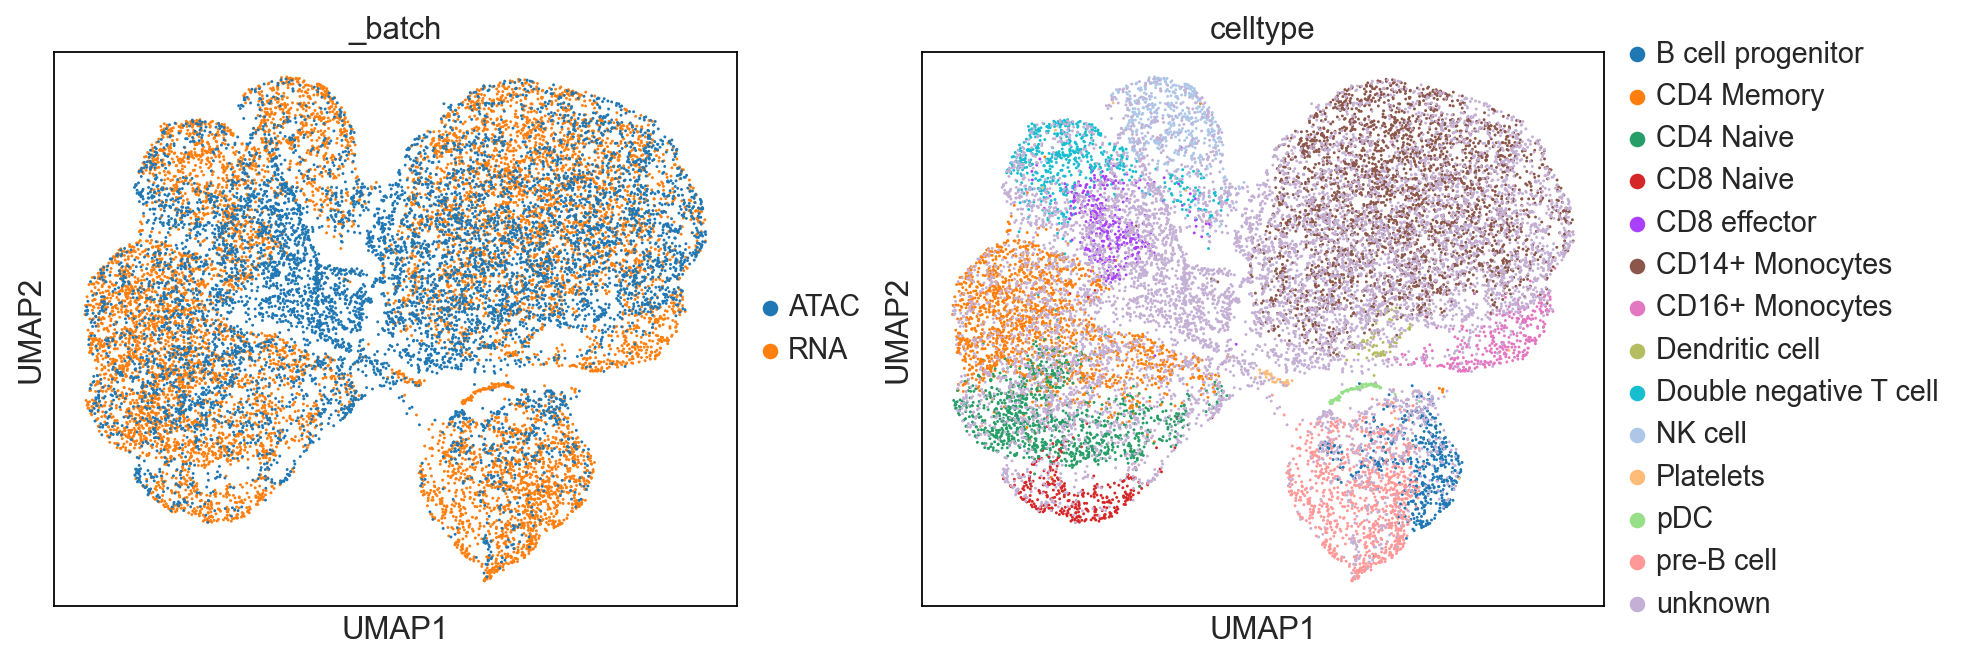

In [8]:
sc.pp.neighbors(adata_integrate, use_rep='X_vipcca')
sc.tl.umap(adata_integrate)

sc.set_figure_params(figsize=[5.5, 4.5])
sc.pl.umap(adata_integrate, color=['_batch', 'celltype'])
